In [1]:
# tensorflow 버전 확인
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
# 내 구글 드라이버에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 1.먼저 본인의 Kaggle 계정에서 API Token 을 다운받습니다.(kaggle.json)
# 2.Kaggle API를 설치합니다.
!pip install kaggle   
# 3.kaggle.json 파일을 VM에 업로드 합니다.
from google.colab import files
files.upload()

In [4]:
# 4.파일이 재대로 업로드 됐는지 확인
!ls -1ha kaggle.json

kaggle.json


In [5]:
# 5.Kaggle API 가 Token을 사용하게 하기 위해 kaggle.json 파일을 ~/.kaggle로 이동 시킵니다.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# 6. Permission Warning 이 일어나지 않도록 권한 부여
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# dataset URL : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
# 7.Kaggle 에서 chest-xray dataset을 다운 받기 위해 API Command 를 복사해서 가져옵니다.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:14<00:00, 153MB/s]
100% 2.29G/2.29G [00:14<00:00, 165MB/s]


In [7]:
# 압축파일 해제
from zipfile import ZipFile

with ZipFile('chest-xray-pneumonia.zip') as z: 
    z.extractall()

In [8]:
# 필요한 패키지와 모듈을 불러옴
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# 저장해 뒀던 모델을 불러옵니다.
new_model = load_model('/content/gdrive/MyDrive/Diagnose_Pneumonia/diagnose_pneumonia_model.h5')

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 64)        0

In [10]:
image_height = 150  # 이미지 높이
image_width = 150   # 이미지 넓이

val_datagen = ImageDataGenerator(rescale=1./255)       # 픽셀 값을 0~1 범위로 변환

# val_datagen 인스턴스를 통해 val dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 val_set 객체를 생성한다.
val_set = val_datagen.flow_from_directory('/content/chest_xray/val',
                                            target_size=(image_width, image_height),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary')

Found 16 images belonging to 2 classes.


In [11]:
# val_set 이 만들어낸 이미지를 우리가 만든 모델을 통해 분류 예측해 봅니다.
predictions = new_model.predict(val_set, steps=16, verbose=1)

16/16 [==============================] - 16s 10ms/step


In [12]:
# predictions shape 확인
predictions.shape

(16, 1)

In [13]:
# 예측결과 확인
predictions

array([[0.08321367],
       [0.44902444],
       [0.00684955],
       [0.7135956 ],
       [0.884502  ],
       [0.6615581 ],
       [0.05366096],
       [0.12649554],
       [0.99928457],
       [0.9605033 ],
       [0.9924353 ],
       [0.8240049 ],
       [0.99510926],
       [0.99981755],
       [0.9983329 ],
       [0.99059886]], dtype=float32)

In [14]:
# val_set 이 만들어 내는 이미지의 클래스 인덱스가 무엇인지 확인해 본다.
print(val_set.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


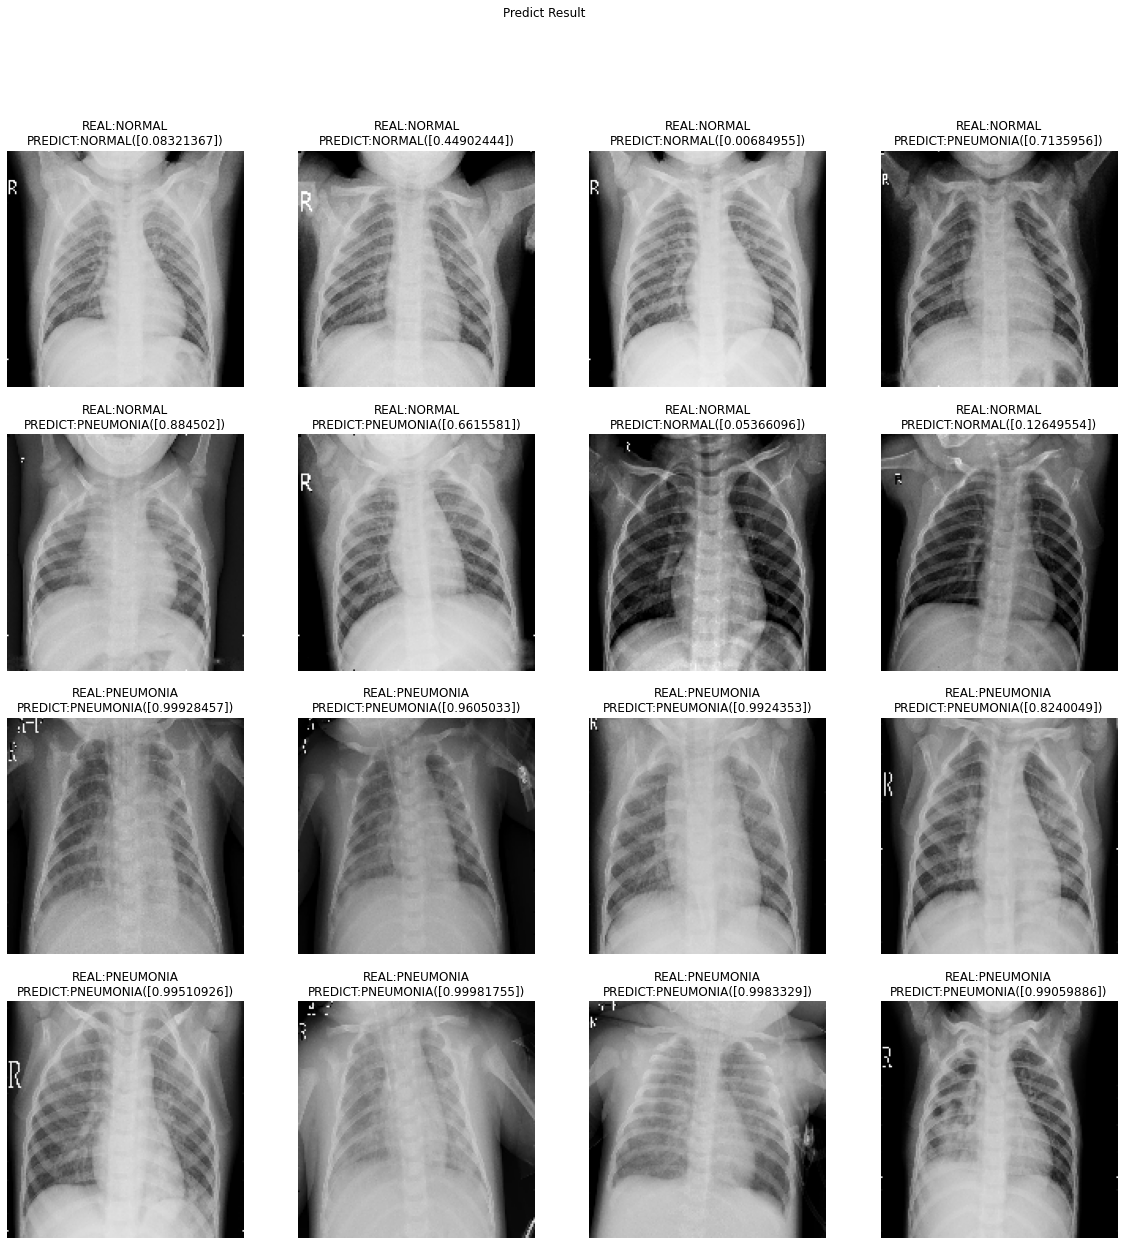

In [15]:
# Predict Result(val_set 가 만들어 낸 이미지를 우리가 만든 모델을 통해 예측한 결과를 보여줍니다.)
f,ax = plt.subplots(4,4,figsize=(20,20))

for i in range(len(predictions)):
    image, label = val_set.next()                                  # val_set 이 만들어 낸 이미지를 하나씩 꺼내온다
    real_class = 'NORMAL' if int(label) == 0 else 'PNEUMONIA'      # val_set 이 만들어 낸 이미지의 label name 을 가져옴
    ax[i//4,i%4].imshow(image[0])                                  # val_set 이 만들어 낸 이미지를 보여줌
    ax[i//4,i%4].axis('off')

    pred_class = 'PNEUMONIA' if predictions[i] > 0.5 else 'NORMAL' # val_set 이 만들어 낸 이미지를 모델을 통해 예측한 결과 값의 label name
    pred_prob = predictions[i]                                     # val_set 이 만들어 낸 이미지를 모델을 통해 예측한 결과(확률값)
    ax[i//4,i%4].set_title('REAL:' + real_class + '\nPREDICT:' + pred_class + '(' + str(pred_prob) + ')')   # title 에 실제값과 모델에 의해 예측된 예측값을 함께 보여준다.

f.suptitle('Predict Result')

plt.show()